Produce PRISM anomaly (June-Oct) maps for each WT  
 - 1 Compute climatology
 - 2 Compute anomaly of each weather type
 - 3 Plotting 

In [13]:
import sys
import datetime
from datetime import datetime
import calendar
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_single
from coexist_func import find_year_top25_wt_smyle
from coexist_func import cal_seasonalmean_wt_smyle
from coexist_func import cal_season_std_smyle
from coexist_func import cal_season_cli_smyle 
from coexist_func import cal_season_ano_smyle
from coexist_func import ax_coastlines_country
from coexist_func import plot_prec_12

In [14]:
# declares a recentered projection for Pacific areas
proj = ccrs.PlateCarree(central_longitude=180)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

# This is very slow 25 ~ 30-minute
# it will take ~ 6 minutes to save a png file
# contourf call is slow with a cartopy axes instance
def plot_S2Swt_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    min_v: minumum value
    max_v: maximum value
    n_lev: number of contour
    cmaps_s: color map
    prec(4_region, 3_wt, nlat, nlon): 4d variable
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    # relableed WT: 0=Monsoon, 1=Normal, 2=Dry
    wt_s = ['Monsoon', 'Normal', 'Dry']
    
    n_wt = len(wt_s)
    
    fig = plt.figure(figsize=(18,14))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
    ct = 1
    for nr in range(prec.shape[0]):
        for wt in range(prec.shape[1]-1,-1,-1):
            ax_s = plt.subplot(4, 3, ct, projection=proj)
            ax_coastlines_country(ax_s)
            ax_s.add_feature(cfeature.STATES, linestyle=':')
            
            im=prec[nr,wt].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                extend='both',
                add_colorbar=False)
            
            ct = ct + 1
            ax_s.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        
            plt.title(region_s[nr] + ' ' +  wt_s[wt] ,fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle( title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
   
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori, extend='both')
    
    # because of the slow rendering of cartopy, I save plot for visulization first
    plt.savefig('prec_prism_ano_12.png', format='png')    

#### setups

- 0.1) Read Centroid domain

In [15]:
dir_o    = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/'
dir_wt   = dir_o + 'WT_S2S/'
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/'
dir_op = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/'  

year_s = 1981
year_e = 2018
n_year = year_e - year_s + 1

n_wt = 3
MONTHS = [6,7,8,9,10]    # months within the NAM season

# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 4
lat_e = DATA['rgrLatWT'].max() + 4
lon_s = DATA['rgrLonWT'].min() - 4 
lon_e = DATA['rgrLonWT'].max() + 4
print('Centroids domain: lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

# there are n_day_s2s = 153 days from June to Oct
dStartDay =datetime(year_s, int(MONTHS[0]), 1, 12)
dStopDay = datetime(year_s, int(MONTHS[-1]), 31, 12)
rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
n_day_s2s = len(rgdTimeDD)
print(n_day_s2s, 'Days in Month ', MONTHS)

Centroids domain: lat: 26.75 - 52.0 lon: -129.25 - -66.5
153 Days in Month  [6, 7, 8, 9, 10]


- 0.2) Read PRISM domain

In [17]:
flnm = dir_prism + 'PRISM_daily_ppt_2000.nc'
print(flnm)
with  xr.open_dataset(flnm) as ds:
    #print(ds)
    prec = ds.PR[0].sel(rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))
    
    latitude = ds.rlat.sel(rlat=slice(lat_e, lat_s)) 
    longitude = ds.rlon.sel(rlon=slice(lon_s, lon_e)) 
    n_lat = len(latitude)
    n_lon = len(longitude)
    print(prec.shape, n_lat, n_lon)

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2000.nc
(557, 1405) 557 1405


#### 1) Comupte climatology

In [18]:
day_s0 = 151  # June 1 0-base
day_e0 = 303  # Oct 31

#data_4d = np.zeros((n_year, n_day_s2s, n_lat, n_lon))

flnm_cli = dir_op + 'prec_clim_Jun-Oct_' + str(year_s) + '-' + str(year_e) + '.nc'

if os.path.isfile(flnm_cli):
    print(flnm_cli, 'exist')
    with  xr.open_dataset(flnm_cli) as ds:
        prec_cli = ds.prec_clim_Jun_Oct  
        print(ds.dims)
else:
    is_first = True
    for year in range(year_s, year_e+1, 1):
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
         
        with  xr.open_dataset(flnm) as ds:
            print(flnm)
            if calendar.isleap(year):
                day_s = day_s0 + 1
                day_e = day_e0 + 1
            else:
                day_s = day_s0
                day_e = day_e0
                
            prec_2d = ds.PR[day_s:day_e+1].sel(rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e)).mean(dim='time')
     
            # concatenate daily data 
            if is_first:
                prec_cli = prec_2d.copy()
                is_first = False
            else:
                prec_cli = prec_cli + prec_2d

    prec_cli = prec_cli/n_year 
    
    prec_xr = xr.DataArray(prec_cli, 
                    coords={'rlat': latitude, 'rlon': longitude},
                    dims = ['rlat', 'rlon'],
                    attrs = {'script':'Ming Ge: prec_S2Swt_ERAI.ipynb',
                            'year': str(year_s) + '-' + str(year_e)})

    prec_xr = prec_xr.rename('prec_clim_Jun_Oct') 
    print(flnm_cli)
    prec_xr.to_netcdf( path = flnm_cli)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_Jun-Oct_1981-2018.nc exist
Frozen({'rlat': 557, 'rlon': 1405})


#### 2 Calculate anomaly of each weather type

In [19]:
region_s = ['Arizona_East', 'Arizona_West', 'NM_North', 'NM_South'] 
#region_s = ['Arizona_East', 'Arizona_West']
n_region = len(region_s)

with  xr.open_dataset(flnm_cli) as ds:
    prec_cli = ds.prec_clim_Jun_Oct      
    print(ds.dims)
    
for region in region_s:
    prec_3d = np.zeros((n_wt, n_lat, n_lon))
    count_1d = np.zeros((n_wt)) 
        
    flnm_o = dir_wt + region + '/prec_prism_ano_' + region + '.nc'
         
    if os.path.isfile(flnm_o):
        print(flnm_o, 'exist')
    else:   
        print('region', region)
        for year in range(year_s, year_e+1, 1):
            flnm_wt = dir_wt + region + '/' + region + '-WTs_' + str(year) +'.cla'               
            wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
            print(flnm_wt)
            
            StartDay = datetime(year, MONTHS[0], 1,  0)
            EndDay   = datetime(year, MONTHS[-1], 31,  23)
            TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
            # read PRISM file
            flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'  
            #print(flnm)
            if calendar.isleap(year):
                day_s = day_s0 + 1
                day_e = day_e0 + 1
            else:
                day_s = day_s0
                day_e = day_e0
                
            with xr.open_dataset(flnm) as ds:
                prec_0 = ds.PR[day_s:day_e+1].sel(rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))
                for nw in wts.wt.unique(): 
                    wts_g = wts.groupby(['wt'])
                    g_ind = wts_g.get_group(nw).index
                    yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                    yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                            
                    # pick WT date
                    iTime_2 = np.isin(TimeDD, yyyymmdd_wt)
                     
                    prec_np = prec_0[iTime_2].values                           
                    prec_3d[nw] = prec_3d[nw] + prec_np.sum(axis=0)   
                    count_1d[nw] = count_1d[nw] + prec_np.shape[0]
                    #print(z500_np.shape[0])
            
        for nw in range(n_wt):                     
            prec_3d[nw] = prec_3d[nw]/count_1d[nw]
            prec_3d[nw] = (prec_3d[nw] - prec_cli)/prec_cli  
            
        prec_xr = xr.DataArray(prec_3d, 
                                coords={'wt':range(n_wt),
                                        'rlat': latitude, 
                                        'rlon': longitude},
                                dims=['wt', 'rlat', 'rlon'],
                                attrs = {'script':'Ming Ge: prec_S2Swt_ERAI.ipynb',
                                         'year': str(year_s) + '-' + str(year_e)})
                     
        prec_xr = prec_xr.rename('prec_ano') 
        print(flnm_o)
        prec_xr.to_netcdf(path = flnm_o) 

Frozen({'rlat': 557, 'rlon': 1405})
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/Arizona_East/prec_prism_ano_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/Arizona_West/prec_prism_ano_Arizona_West.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/NM_North/prec_prism_ano_NM_North.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/NM_South/prec_prism_ano_NM_South.nc exist


#### 3 plotting

In [20]:

prec_4d = np.zeros((n_region, n_wt, n_lat, n_lon))

nr = 0
for region in region_s:
    flnm = dir_wt + region + '/prec_prism_ano_' + region + '.nc'
    print(flnm)
    with  xr.open_dataset(flnm) as ds:
        prec_4d[nr] = ds.prec_ano
    nr = nr + 1
        
prec_xr = xr.DataArray(prec_4d, 
                coords={'rlat': latitude, 'rlon': longitude, 'wt':range(n_wt), 'region':range(n_region)},
                dims=["region", "wt", "rlat", "rlon"])

/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/Arizona_East/prec_prism_ano_Arizona_East.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/Arizona_West/prec_prism_ano_Arizona_West.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/NM_North/prec_prism_ano_NM_North.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT_S2S/NM_South/prec_prism_ano_NM_South.nc


CPU times: user 5min 15s, sys: 12.6 s, total: 5min 27s
Wall time: 5min 38s


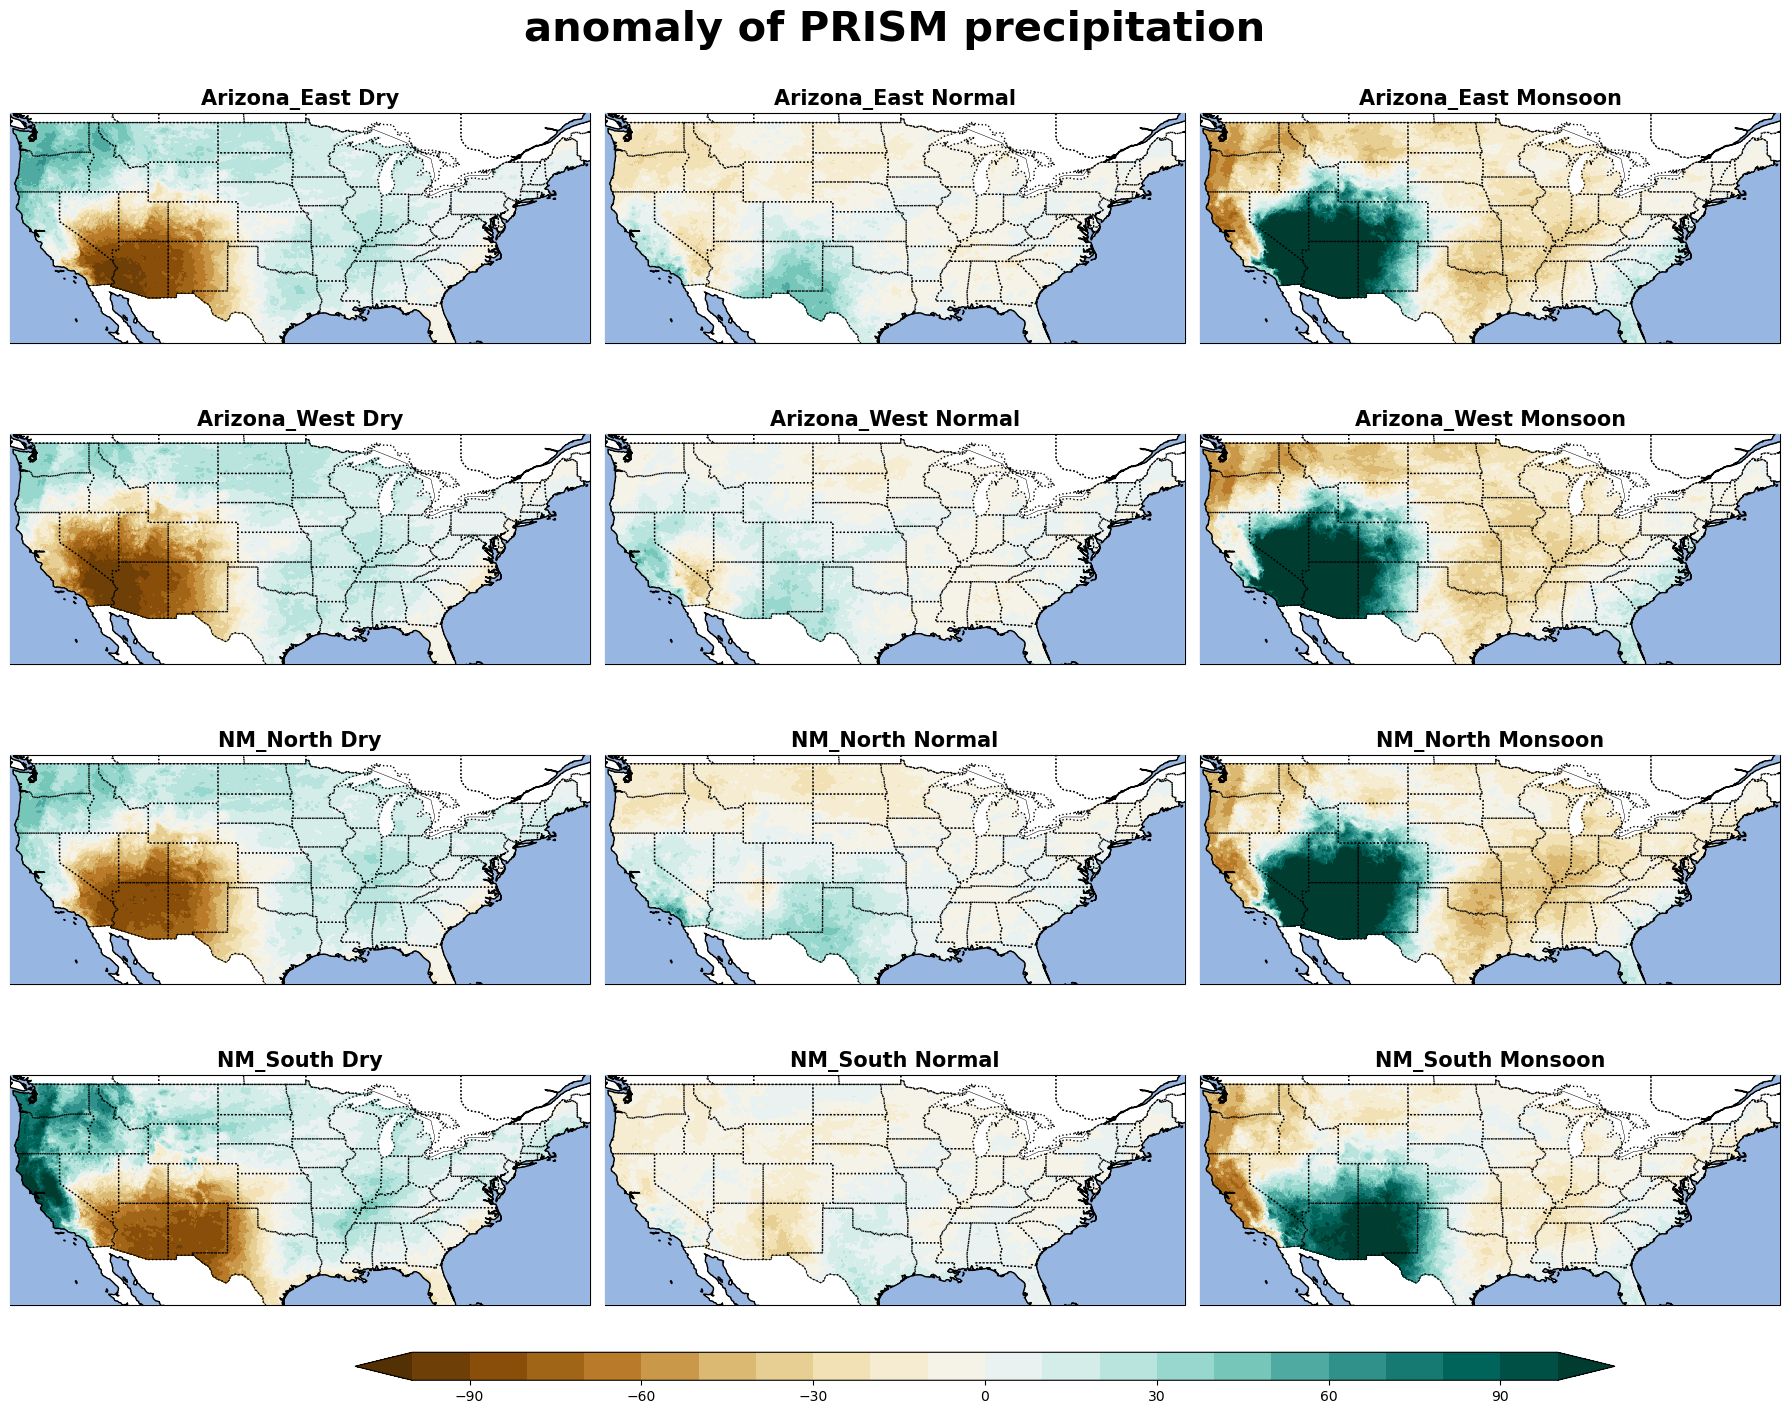

In [10]:
%%time
plot_S2Swt_12(prec_xr*100, -100, 100, 21, 'BrBG', 'horizontal', 'anomaly of PRISM precipitation')